Load packages/libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.utils import resample

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from scipy.stats import boxcox

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.metrics import classification_report, confusion_matrix, auc, roc_curve

from sklearn.pipeline import Pipeline

from sklearn.decomposition import PCA

from sklearn.feature_selection import f_classif, SelectKBest, SelectFromModel

from sklearn.linear_model import LogisticRegression

from sklearn.neighbors import KNeighborsClassifier

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

from sklearn.svm import SVC

In [3]:
# load the pickled dataframe
cust_df = pd.read_pickle('dummies_no_out')

In [4]:
cust_df.head()

,sessions,duration,mega_bytes,case_count,comp_flag,train_flag,pcs_flag,holiday_flag,churn,base_AFACDY,...,base_MCCMUJ,base_MCCPEN,base_MCHAWI,base_MCMIRA,base_MCPRSI,base_MCQTCO,base_MCSDRC,base_MCSMTH,base_MCYUMA,base_TOKYO
account_num,,,,,,,,,,,,,,,,,,,,,
2181914.0,878,1.005832e+06,4894219.706,0.0,0.0,0.0,1.0,0.0,1.0,0,...,0,0,0,0,0,0,0,0,0,0
9858995.0,240,2.289019e+05,4664070.710,0.0,0.0,1.0,0.0,0.0,1.0,0,...,0,0,0,0,0,0,0,0,0,0
6105431.0,1922,1.190221e+06,4817499.665,0.0,1.0,0.0,0.0,0.0,1.0,0,...,0,0,0,0,0,0,0,0,0,0
5014154.0,2444,1.791515e+06,4504119.671,0.0,0.0,0.0,0.0,0.0,1.0,0,...,0,0,0,0,0,0,0,0,0,0
6735499.0,1474,2.024315e+06,4919416.722,0.0,0.0,0.0,0.0,0.0,1.0,0,...,0,0,0,0,0,0,0,0,0,0


## Resample to balance the dataset - upsample the minority class (customers who churn) so it is the same size as the majority (customers who do not churn)

In [5]:
majority = cust_df[cust_df['churn']==0]
minority = cust_df[cust_df['churn']==1]
print(len(majority), len(minority))

31537 18893


In [6]:
minority_upsampled = resample(minority, 
                                 replace=True,     
                                 n_samples=31537,    
                                 random_state=42) 
 
upsampled = pd.concat([majority, minority_upsampled])
 
upsampled['churn'].value_counts()

1.0    31537
0.0    31537
Name: churn, dtype: int64

If we didn't resample the dataset to balance the churn and non-churn classes, we could also look carefully at the classification metrics and confusion matrix for each model. The confusion matrix gives us a breakdown of correct and incorrect predictions for each class. The precision and recall metrics for a classifier tell us in different ways how accurate our model predicts the class. Depending on what we want to avoid more - incorrectly predicting a customer will churn when they don't, or incorrectly predicting that they won't churn when they do - we would want to chose a different threshold for our model's class decisions based on these values.

* Recall: when a customer churns, how often does the model predict that correctly? 

* Precision: when a classifier predicts a customer will churn, how often does that customer actually churn?

We can also look at the F1 score (a weighted average of precision and recall) or Kappa (accuracy normalized by the imbalance of the classes).

## Separate "churn" as the target (y) and train-test-split the dataset

Original, imbalanced dataset:

In [7]:
X = cust_df.drop(['churn'], axis=1)
y = cust_df['churn']

In [8]:
X.shape

(50430, 66)

In [9]:
y.shape

(50430,)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state = 42)

Resampled, balanced dataset:

In [11]:
X_resamp = upsampled.drop(['churn'], axis=1)
y_resamp = upsampled['churn']

In [12]:
X_resamp.shape

(63074, 66)

In [13]:
y_resamp.shape

(63074,)

In [14]:
X_train_rs, X_test_rs, y_train_rs, y_test_rs = train_test_split(X_resamp, y_resamp, test_size = .3, random_state = 42)

## Scale the data

In [15]:
scaler = StandardScaler()

In [16]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [17]:
X_train_scaled_rs = scaler.fit_transform(X_train_rs)
X_test_scaled_rs = scaler.transform(X_test_rs)

In [18]:
X_scaled = scaler.fit_transform(X)

In [19]:
X_scaled_rs = scaler.fit_transform(X_resamp)

## Principal Component Analysis (PCA)

In [19]:
pca=PCA(n_components=10)

In [20]:
X_pca = pca.fit_transform(X_scaled_rs)

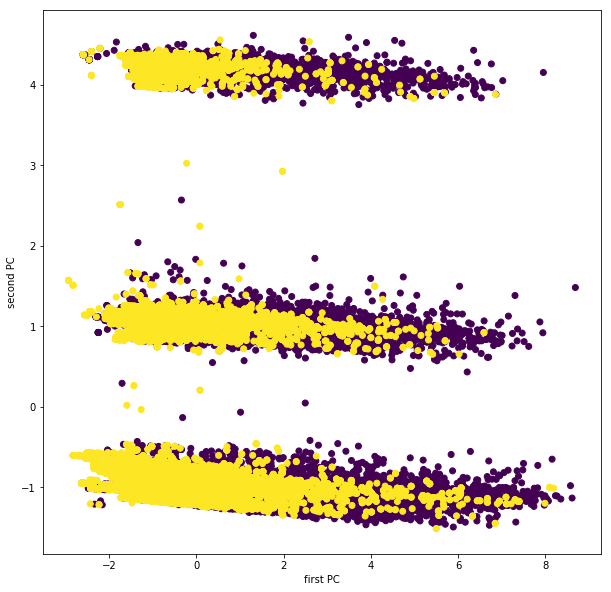

In [21]:
plt.figure(figsize=(10,10))
plt.scatter(X_pca[:,0], X_pca[:,1], c=y_resamp)

plt.xlabel("first PC")
plt.ylabel("second PC")

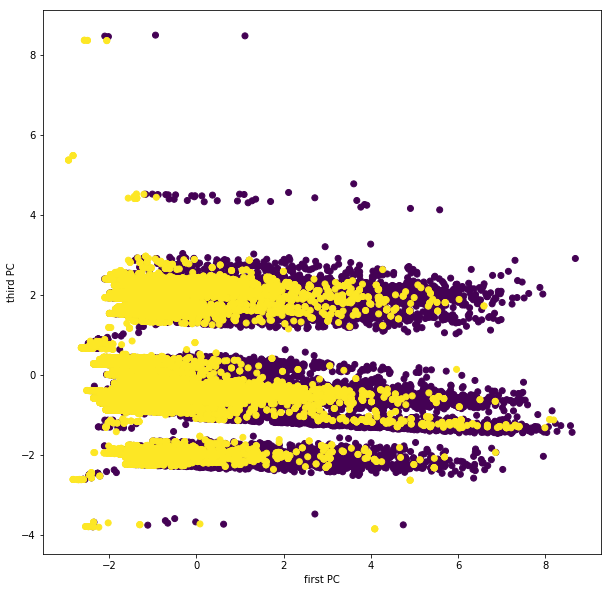

In [22]:
plt.figure(figsize=(10,10))
plt.scatter(X_pca[:,0], X_pca[:,2], c=y_resamp)

plt.xlabel("first PC")
plt.ylabel("third PC")

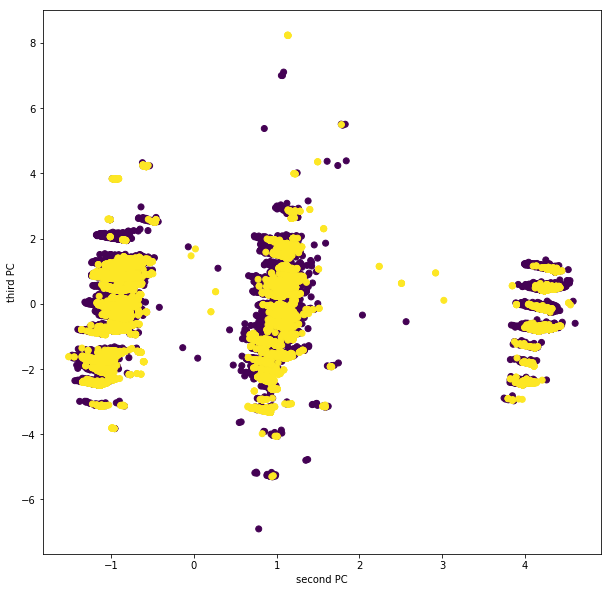

In [23]:
plt.figure(figsize=(10,10))
plt.scatter(X_pca[:,1], X_pca[:,3], c=y_resamp)

plt.xlabel("second PC")
plt.ylabel("third PC")

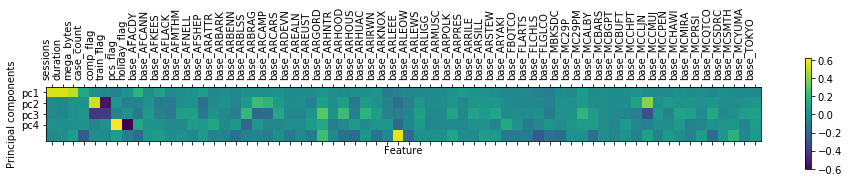

In [24]:
plt.matshow(pca.components_[0:5], cmap='viridis')
plt.yticks([0,1,2,3], ['pc1', 'pc2', 'pc3', 'pc4'])
plt.colorbar()
plt.xticks(range(len(X.columns)),
          X.columns, rotation=90, ha='right')
plt.xlabel('Feature')
plt.ylabel('Principal components')

This looks like the first principal component contains mostly the level of use features.

Look at explained variance for the PCA:

In [25]:
pca.explained_variance_ratio_

array([ 0.04449346,  0.03860237,  0.02380626,  0.02079955,  0.01665859,
        0.01650163,  0.01614731,  0.01601675,  0.01579542,  0.01574   ])

Scree plot showing the explained variance for each of the principal components and the cumulative explained variance:

<Container object of 10 artists>

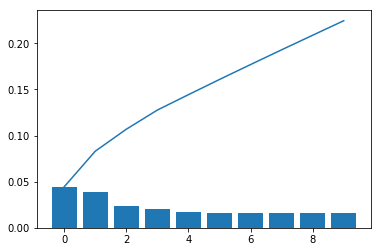

In [26]:
evr = pca.explained_variance_ratio_
x = list(range(len(evr)))

plt.plot(x, np.cumsum(evr))
plt.bar(x, evr)

PCA with 20 components explains only about 40% of the variance in the data. Therefore we wouldn't want to use PCA to reduce the dimensionality in our data - we would lose too much information, since we can't capture a lot of the variance in a small number of components relative to the number of features in the original dataset. As a next step, we could try doing a Kernel PCA to see if it deals with non-linearity in the data.

## Predictive models

#### Logistic regression

With non-resampled data:

In [36]:
lr = LogisticRegression(class_weight='balanced')

In [28]:
lr_original = lr.fit(X_train_scaled, y_train)

In [29]:
lr_original.score(X_train_scaled, y_train)

0.69714738959236278

In [30]:
lr_original.score(X_test_scaled, y_test)

0.6940974287791658

In [31]:
y_test_pred = lr_original.predict(X_test_scaled)

In [32]:
confusion = confusion_matrix(y_test, y_test_pred)
pd.DataFrame(confusion, columns=['predicted non-churn', 'predicted churn'], index=['true non-churn', 'true churn'])

,predicted non-churn,predicted churn
true non-churn,6223,3207
true churn,1421,4278


In [33]:
print(classification_report(y_test, y_test_pred))

             precision    recall  f1-score   support

        0.0       0.81      0.66      0.73      9430
        1.0       0.57      0.75      0.65      5699

avg / total       0.72      0.69      0.70     15129



The accuracy is not much better than the baseline - if we guessed 'non-churn' every time, we would be accurate 64% of the time since 64% of customers don't churn. Let's see how it does with our manually balanced classes data.

In [49]:
lr_rs = lr.fit(X_train_scaled_rs, y_train_rs)

In [35]:
lr_rs.score(X_train_scaled_rs, y_train_rs)

0.71189780525922408

In [36]:
lr_rs.score(X_test_scaled_rs, y_test_rs)

0.70918987475558848

In [37]:
y_test_pred_rs = lr_rs.predict(X_test_scaled_rs)

In [38]:
confusion_rs = confusion_matrix(y_test_rs, y_test_pred_rs)
pd.DataFrame(confusion_rs, columns=['predicted non-churn', 'predicted churn'], index=['true non-churn', 'true churn'])

,predicted non-churn,predicted churn
true non-churn,6268,3157
true churn,2346,7152


In [39]:
print(classification_report(y_test_rs, y_test_pred_rs))

             precision    recall  f1-score   support

        0.0       0.73      0.67      0.69      9425
        1.0       0.69      0.75      0.72      9498

avg / total       0.71      0.71      0.71     18923



This is actually much better, since the baseline accuracy would now be only 50% (if guessing randomly, we would have a 50% of correctly predicting churn).

#### KNearest Neighbors Classifier

In [40]:
knn = KNeighborsClassifier()

In [41]:
knn.fit(X_train_scaled_rs, y_train_rs)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [ ]:
knn.score(X_train_scaled_rs, y_train_rs)

In [ ]:
knn.score(X_test_scaled_rs, y_test_rs)

0.72155577868202714

About the same as logistic regression.

#### AdaBoost

In [ ]:
# default base estimator is DecisionTree
ada = AdaBoostClassifier()

In [ ]:
ada.fit(X_train_scaled_rs, y_train_rs)

In [ ]:
ada.score(X_train_scaled_rs, y_train_rs)

In [ ]:
ada.score(X_test_scaled_rs, y_test_rs)

The AdaBoost doesn't really improve our score over KNN or Logistic Regression.

#### Random Forest

With original dataset (unbalanced):

In [20]:
rf = RandomForestClassifier(class_weight='balanced')

In [21]:
rf.fit(X_train_scaled, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [22]:
rf.score(X_train_scaled, y_train)

0.97923571570210477

In [23]:
rf.score(X_test_scaled, y_test)

0.69548549144028027

In [24]:
y_test_pred = rf.predict(X_test_scaled)

In [25]:
confusion = confusion_matrix(y_test, y_test_pred)
pd.DataFrame(confusion, columns=['predicted non-churn', 'predicted churn'], index=['true non-churn', 'true churn'])

,predicted non-churn,predicted churn
true non-churn,7768,1662
true churn,2945,2754


In [26]:
print(classification_report(y_test, y_test_pred))

             precision    recall  f1-score   support

        0.0       0.73      0.82      0.77      9430
        1.0       0.62      0.48      0.54      5699

avg / total       0.69      0.70      0.69     15129



Resampled, balanced dataset:

In [27]:
rf2 = RandomForestClassifier()

In [28]:
rf2.fit(X_train_scaled_rs, y_train_rs)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [29]:
rf2.score(X_train_scaled_rs, y_train_rs)

0.98987565400557176

In [30]:
rf2.score(X_test_scaled_rs, y_test_rs)

0.81345452623791159

In [31]:
y_test_pred = rf2.predict(X_test_scaled_rs)

In [32]:
confusion = confusion_matrix(y_test_rs, y_test_pred)
pd.DataFrame(confusion, columns=['predicted non-churn', 'predicted churn'], index=['true non-churn', 'true churn'])

,predicted non-churn,predicted churn
true non-churn,7435,1990
true churn,1540,7958


In [33]:
print(classification_report(y_test_rs, y_test_pred))

             precision    recall  f1-score   support

        0.0       0.83      0.79      0.81      9425
        1.0       0.80      0.84      0.82      9498

avg / total       0.81      0.81      0.81     18923



Random Forest has more accurate predictions, which is to be expected. It also does better with our manually balanced data. It is clearly overfitting to the training data, though.

#### Use GridSearch CV to find the optimal hyperparameters for models

GridSearch the Logistic Regression model with different parameters for regularization strength and technique:

In [34]:
lr_params = {
    'C':np.logspace(-3,3,3),
    'penalty':['l2','l1']
}

In [37]:
lr_gs = GridSearchCV(lr, param_grid=lr_params)

In [38]:
lr_gs.fit(X_train_scaled_rs, y_train_rs)

GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': array([  1.00000e-03,   1.00000e+00,   1.00000e+03]), 'penalty': ['l2', 'l1']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [39]:
pd.DataFrame(lr_gs.cv_results_).T

,0,1,2,3,4,5
mean_fit_time,0.506596,0.475102,1.12845,3.24974,1.19101,6.12604
mean_score_time,0.0130754,0.00689665,0.00520619,0.00628034,0.00523623,0.00518401
mean_test_score,0.711875,0.696677,0.710765,0.710879,0.710765,0.710743
mean_train_score,0.712758,0.696813,0.71209,0.712102,0.712079,0.712079
param_C,0.001,0.001,1,1,1000,1000
param_penalty,l2,l1,l2,l1,l2,l1
params,"{'C': 0.001, 'penalty': 'l2'}","{'C': 0.001, 'penalty': 'l1'}","{'C': 1.0, 'penalty': 'l2'}","{'C': 1.0, 'penalty': 'l1'}","{'C': 1000.0, 'penalty': 'l2'}","{'C': 1000.0, 'penalty': 'l1'}"
rank_test_score,1,6,3,2,3,5
split0_test_score,0.715586,0.697038,0.715179,0.715111,0.714975,0.715043
split0_train_score,0.711073,0.69755,0.710121,0.710087,0.710087,0.710121


Tuning the hyperparameters for regularization didn't really improve the predictive accuracy of our logistic regression model. The train and test scores are still around 71%

Random Forest:

In [40]:
# try different limits for the max depth of the RandomForest to prevent overfitting
params = {
    'max_depth':[5, 10, 15, 20, 30, 40]
}

In [41]:
gs_rf = GridSearchCV(rf, param_grid=params)

In [42]:
gs_rf.fit(X_train_scaled_rs, y_train_rs)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': [5, 10, 15, 20, 30, 40]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [43]:
pd.DataFrame(gs_rf.cv_results_).T

,0,1,2,3,4,5
mean_fit_time,0.322582,0.446357,0.582398,0.658584,0.752987,0.749984
mean_score_time,0.0250794,0.0248992,0.0351721,0.0440656,0.0508648,0.0549671
mean_test_score,0.703608,0.715431,0.739055,0.756042,0.77321,0.778918
mean_train_score,0.706518,0.736699,0.807116,0.884306,0.959004,0.983885
param_max_depth,5,10,15,20,30,40
params,{'max_depth': 5},{'max_depth': 10},{'max_depth': 15},{'max_depth': 20},{'max_depth': 30},{'max_depth': 40}
rank_test_score,6,5,4,3,2,1
split0_test_score,0.705123,0.717896,0.7376,0.759682,0.774086,0.781356
split0_train_score,0.70105,0.737641,0.800428,0.884517,0.956511,0.981891
split1_test_score,0.70619,0.713393,0.738262,0.754366,0.772372,0.778827


Limiting the max depth to 15 results in the best test score (74%) without overfitting too much to the training data. This is our winning model so far.

## Feature importances

Use SelectKBest with f-scores and p-values to see top features

In [44]:
skb_fc = SelectKBest(score_func=f_classif, k=5)

In [45]:
skb_fc.fit(X_train_scaled_rs, y_train_rs)

/Users/emmafreeman/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [51] are constant.
  UserWarning)
/Users/emmafreeman/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


SelectKBest(k=5, score_func=<function f_classif at 0x10fab8048>)

In [46]:
feat_list = list(zip(X_resamp.columns, skb_fc.scores_, skb_fc.pvalues_))
feat_list.sort(key=lambda x: x[2], reverse=False)
pd.DataFrame(feat_list, columns=['feature','f-score','p-value'])

,feature,f-score,p-value
0,sessions,7599.489346,0.000000e+00
1,duration,8053.460864,0.000000e+00
2,mega_bytes,6651.066495,0.000000e+00
3,base_ARKNOX,1167.747788,1.247068e-252
4,base_ARHOUS,572.051306,1.269946e-125
5,base_ARLEEE,448.676186,4.366694e-99
6,case_count,430.424838,3.742845e-95
7,base_FLCHLS,397.642632,4.391264e-88
8,base_AFSHEP,286.157610,5.441402e-64
9,holiday_flag,215.905304,9.223626e-49


The very high f-scores and p-values of 0 tell us that sessions, duration, and megabytes are the most predictive of churn, followed by certain bases where we would expect to see high churn rates. These are the features that are the most correlated with churn but they could be positive or negative - predictive or anti-predictive of churn.

What features did the logistic regression determine are predictive of churn?

In [50]:
cols = X_train_rs.columns
coef = abs(lr_rs.coef_)
zipped = list(zip(cols, coef[0]))
zipped_df = pd.DataFrame(zipped, columns=['feature', 'importance'])

In [51]:
zipped_df.sort_values(by='importance', ascending=False)

,feature,importance
1,duration,0.633970
2,mega_bytes,0.390261
31,base_ARKNOX,0.364565
28,base_ARHOUS,0.242550
45,base_FLCHLS,0.184977
7,holiday_flag,0.178970
32,base_ARLEEE,0.168706
18,base_ARBLSS,0.158028
55,base_MCCLJN,0.148688
24,base_AREUST,0.138084


Again we see the "level of use" features as by far the most predictive of churn, but 'sessions' dropped down. We also see certain bases again, along with the holiday flag for if the account was created in Nov. or Dec.

What about the RandomForest model?

In [52]:
cols = X_train_rs.columns
imp = rf.feature_importances_

zipped = list(zip(cols, imp))
zipped_df = pd.DataFrame(zipped, columns=['feature', 'importance'])

In [53]:
zipped_df.sort_values(by='importance', ascending=False)

,feature,importance
0,sessions,0.318760
1,duration,0.254848
2,mega_bytes,0.254738
3,case_count,0.019067
6,pcs_flag,0.015061
7,holiday_flag,0.012735
31,base_ARKNOX,0.012513
28,base_ARHOUS,0.009671
32,base_ARLEEE,0.007735
18,base_ARBLSS,0.005545


Same features again. We can safely say that the "level of use" features, a few of the bases, and potentially the holiday flag and pcs_flag are highly predictive of whether a customer account churns.

## Next steps:

Our best score for the predictive classification model was 74% (with a baseline of 50%). This isn't bad but we could try doing some more sophisticated modeling techniques like model stacking to try and improve our accuracy score.

I would also go back and look at doing some more feature engineering and clustering by base or type of customer to find more patterns in the data, and build individual models for the different types of customer.